# MAJEURE IA : TP projet vision

Pour lancer Tensor Board : 

----

In [2]:
import os, random
import datetime
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

Using TensorFlow backend.


## Import Data

### Images

#### Read image (grayscale)

In [55]:
filename = 'images/train/base2.png'
src = cv2.imread(cv2.samples.findFile(filename), cv2.IMREAD_GRAYSCALE)

#### Show grayscaled image

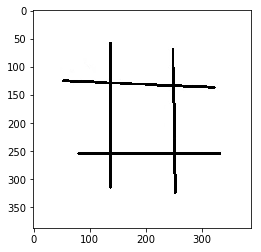

In [56]:
BGR_src = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR) # To display with mathplotlib
plt.imshow(BGR_src)
plt.show()

#### Reduce noise with a kernel 3x3

In [57]:
src = cv2.blur(src, (3, 3))

#### Show blured image

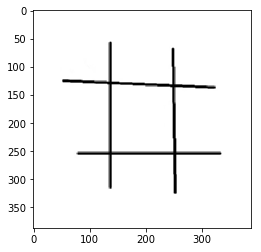

In [58]:
BGR_src = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR) # To display with mathplotlib
plt.imshow(BGR_src)
plt.show()

#### Apply edge detection

In [59]:
def edge_detection(img):
    low_threshold = 25
    ratio = 3 # Recommended
    kernel_size = 3
    # Use Canny fonction
    return cv2.Canny(src, low_threshold, low_threshold*ratio, None, kernel_size)

detected_edges = edge_detection(src)

#### Show detected edges

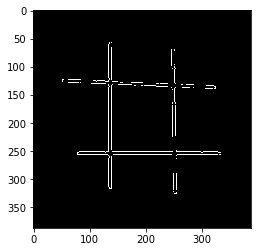

In [60]:
BGR_detected_edges = cv2.cvtColor(detected_edges, cv2.COLOR_GRAY2BGR) # To display with mathplotlib
plt.imshow(BGR_detected_edges)
plt.show()

#### Standard Hough Line Transform

In [111]:
lines = cv2.HoughLines(detected_edges, 1.5, np.pi / 180, 150, None, 0, 0)

#### Draw the lines

In [112]:
# Lines points
vertical_lines = []
horizontal_lines = []

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        # Replace '~ 1000' and '~ -1000' values by 387 (img pixels height/width) and 0
        pt1_x, pt1_y = pt1 
        pt2_x, pt2_y = pt2 
        if pt1_x > 0:
            vertical_avg = int((pt1_x+pt2_x)/2)
            tmp_pt1 = (vertical_avg, 387)
            tmp_pt2 = (vertical_avg, 0)
            vertical_lines.append([tmp_pt1, tmp_pt2])
        else:
            horizontal_avg = int((pt1_y+pt2_y)/2)
            tmp_pt1 = (0, horizontal_avg)
            tmp_pt2 = (387, horizontal_avg)
            horizontal_lines.append([tmp_pt1, tmp_pt2])
        # Draw line on the image copy
        cv2.line(BGR_detected_edges, tmp_pt1, tmp_pt2, (0,0,255), 3, cv2.LINE_AA)

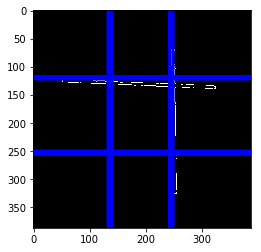

In [113]:
# Show results
plt.imshow(BGR_detected_edges)
plt.show()

#### Clean lines (mean of closed lines)

In [114]:
def clean_lines(lines_to_clean, tolerance):
    tolerance_px = (387 / 100) * tolerance
    tmp_lines = []
    for index, value in enumerate(lines_to_clean):
        if index > 0:
            # Line start point
            line_start_x = value[0][0]
            line_start_y = value[0][1]
            # Previous line start point
            prev_line_start_x = lines_to_clean[index-1][0][0]
            prev_line_start_y = lines_to_clean[index-1][0][1]
            # Differences
            diff_x = np.absolute(line_start_x - prev_line_start_x)
            diff_y = np.absolute(line_start_y - prev_line_start_y)
            # If below the tolerance (number of pixel)
            if (diff_x < tolerance_px) and (diff_y < tolerance_px):
                # Mean of points
                new_points = [[line_start_x, prev_line_start_x], [line_start_y, prev_line_start_y]]
                tmp_lines.insert(index-1, np.mean(new_points, axis=1))
                del tmp_lines[index-1]
            else:
                tmp_lines.insert(index, value)
        else:
            tmp_lines.insert(index, value)
    return tmp_lines

# Define tolerance for cleaning (% of px)
tolerance = 20     

vertical_lines = clean_lines(vertical_lines, tolerance)
horizontal_lines = clean_lines(horizontal_lines, tolerance)

#### Check if match a TicTacToe plate in detected lines

In [115]:
print('Lignes verticales :')
print(vertical_lines)
print('Lignes horizontales :')
print(horizontal_lines)
if len(vertical_lines) > 2 or len(horizontal_lines) > 2:
    print('Error: the TicTacToe plate must have 2 vertical and 2 horizontal lines like a sharp "#"...')
    print('{} vertical and {} horizontal lines detected'.format(len(vertical_lines), len(horizontal_lines)))

Lignes verticales :
[[(139, 387), (139, 0)], [(248, 387), (248, 0)]]
Lignes horizontales :
[[(0, 256), (387, 256)], [(0, 122), (387, 122)]]


#### Draw cleaned lines

In [116]:
img_with_cleaned_lines = cv2.cvtColor(detected_edges, cv2.COLOR_GRAY2BGR) # To display with mathplotlib

In [117]:
for index, value in enumerate(vertical_lines):
    # Draw line on the image copy
    cv2.line(img_with_cleaned_lines, value[0], value[1], (0,0,255), 3, cv2.LINE_AA)
for index, value in enumerate(horizontal_lines):
    # Draw line on the image copy
    cv2.line(img_with_cleaned_lines, value[0], value[1], (0,0,255), 3, cv2.LINE_AA)

#### Show cleaned lines

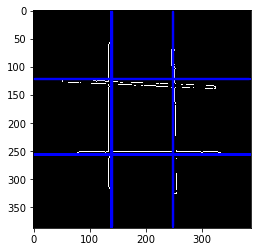

In [118]:
plt.imshow(img_with_cleaned_lines)
plt.show()

#### Create the cropping matrice

We need to obtain a matrice of 9 parts represented by : 
```python
[
    (bottom_left_point_x, bottom_left_point_y), # The bottom-left point tuple
    width(px), # width (in pixels)
    height(px) # height (in pixels)
]
```

like:

| .       | 1                            | 2                            | 3                            |
| :-----: | :--------------------------: | :--------------------------: | :--------------------------: |
| **1**   | [(bottom-left), width, height] | [(bottom-left), width, height] | [(bottom-left), width, height] |
| **2**   | [(bottom-left), width, height] | [(bottom-left), width, height] | [(bottom-left), width, height] |
| **3**   | [(bottom-left), width, height] | [(bottom-left), width, height] | [(bottom-left), width, height] |

In [119]:
# Loop from top left because lines are sorted from 
# Add vertical and horizontal limiter lines
vertical_lines.append([(387, 387), (387, 0)])
horizontal_lines.append([(0, 0), (387, 0)])

In [130]:
# Init temporary bottom-left point reference
tmp_point = {'x': 0, 'y': 387}
# Init empty cropping_matrice
cropping_matrice = []
# Height reference (start from top of image)
ref_height_point = 387
i = 0
# For each horizontal lines
for hl_index, hl_val in enumerate(horizontal_lines):
    # Init tmp_point to horizontal line start point
    tmp_point['x'], tmp_point['y'] = hl_val[0]
    # Compute height
    height = ref_height_point - tmp_point['y']
    # Compute ref_height_point (to remember last horizontal line)
    ref_height_point = tmp_point['y']
    # For each vertical lines
    for vl_index, vl_val in enumerate(vertical_lines):
        # Compute width
        width = vl_val[0][0] - tmp_point['x']
        # Append in the cropping matrice
        cropping_matrice.append([(tmp_point['x'], tmp_point['y']), width, height])
        # Next temporary point
        tmp_point['x'] = vl_val[0][0]
        i = i+1
        print('Part ' + str(i) + ' -> tmp_point : ' + str(tmp_point) + ', width : ' + str(width) + ', height : ' + str(height))


Part 1 -> tmp_point : {'x': 139, 'y': 256}, width : 139, height : 131
Part 2 -> tmp_point : {'x': 248, 'y': 256}, width : 109, height : 131
Part 3 -> tmp_point : {'x': 387, 'y': 256}, width : 139, height : 131
Part 4 -> tmp_point : {'x': 139, 'y': 122}, width : 139, height : 134
Part 5 -> tmp_point : {'x': 248, 'y': 122}, width : 109, height : 134
Part 6 -> tmp_point : {'x': 387, 'y': 122}, width : 139, height : 134
Part 7 -> tmp_point : {'x': 139, 'y': 0}, width : 139, height : 122
Part 8 -> tmp_point : {'x': 248, 'y': 0}, width : 109, height : 122
Part 9 -> tmp_point : {'x': 387, 'y': 0}, width : 139, height : 122


#### Show the computed parts

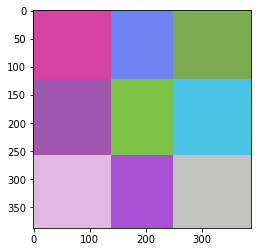

In [139]:
img_with_cropping_areas = cv2.cvtColor(detected_edges, cv2.COLOR_GRAY2BGR) # To display with mathplotlib
for index, value in enumerate(cropping_matrice):
    r_color = random.randint(25, 255)
    g_color = random.randint(25, 255)
    b_color = random.randint(25, 255)
    bottom_left_pt = value[0]
    top_right_pt = (value[0][0] + value[1], value[0][1] + value[2])
    cv2.rectangle(img_with_cropping_areas, bottom_left_pt, top_right_pt, (r_color, g_color, b_color), -1)
    # Show result
plt.imshow(img_with_cropping_areas)
plt.show()

#### Create the cropped image matrice

In [163]:
cropped_img = []
copy = cv2.cvtColor(src.copy(), cv2.COLOR_GRAY2BGR) # BGR 
for index, value in enumerate(cropping_matrice):
    bottom_left_pt = value[0]
    tmp_part = copy[bottom_left_pt[1]:bottom_left_pt[1]+value[2], bottom_left_pt[0]:bottom_left_pt[0]+value[1]]
    cropped_img.append(tmp_part)

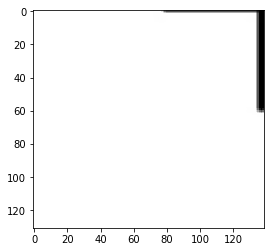

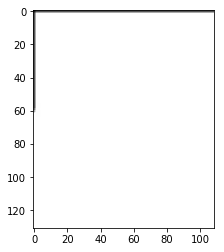

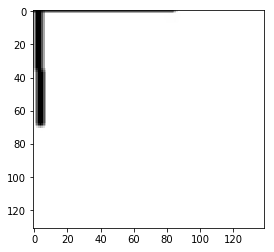

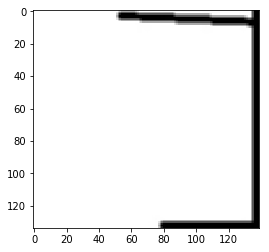

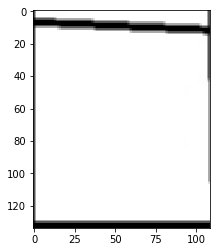

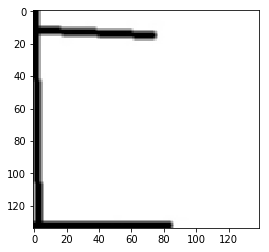

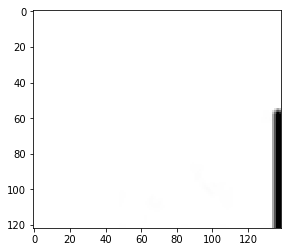

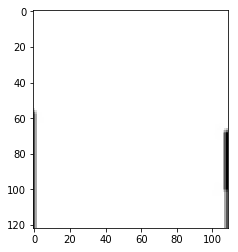

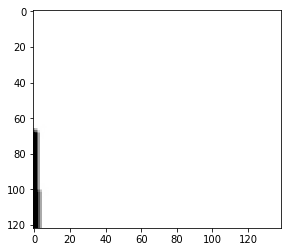

In [164]:
for index, value in enumerate(cropped_img):
    plt.figure()
    plt.imshow(value)

In [10]:
TRAIN_DIR = 'images/train/'
TEST_DIR = 'images/test/'

ROWS = 387
COLS = 387
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [4]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image # nos données sont de la forme (387, 387, 3)
        if i%10 == 0: print('Processed {} of {}'.format(i, count)) # Affiche tous les 10 résultats
    
    return data


In [5]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (0, 387, 387, 3)
Test shape: (0, 387, 387, 3)


### Normalization

In [5]:
def normalize_images(images):
    recaled_images = images/255
    return recaled_images

In [6]:
scaled_train = normalize_images(train)
scaled_test = normalize_images(test)

### Labels

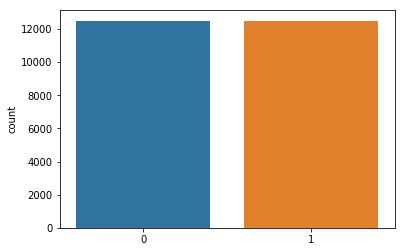

In [7]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

### Plot

In [8]:
def plot_image(idx):
    print("Label : " + str(labels[idx]))
    plt.imshow(scaled_train[idx])
    plt.show()

In [9]:
ramdom_samples = np.random.randint(0, len(scaled_train), 5)

Label : 1


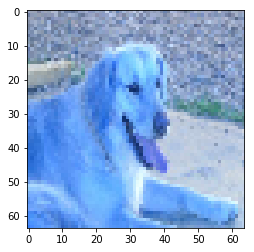

Label : 1


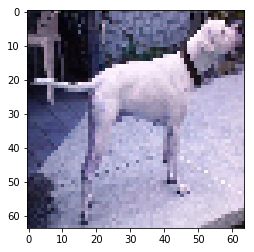

Label : 1


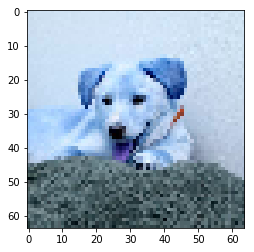

Label : 0


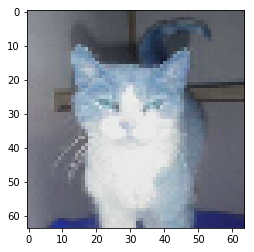

Label : 1


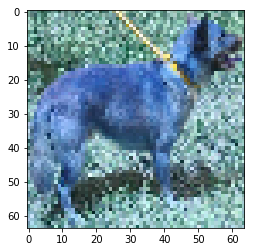

In [10]:
for i in ramdom_samples:
    plot_image(i)

## Data Augmentation

### Declare data generator

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25)

### Launch generator

In [12]:
datagen.fit(scaled_train)

## Model

In [35]:
def model():
    backend.clear_session()
    model = Sequential()
    
    ###### Architecture ######
    ##### Conv Layer 1 #####
    model.add(Convolution2D(filters=32,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same', 
                            input_shape=(ROWS, COLS, CHANNELS), 
                            activation='relu'))
    model.add(Convolution2D(filters=32,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same', 
                            input_shape=(ROWS, COLS, CHANNELS), 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### Conv Layer 2 #####
    model.add(Convolution2D(filters=64,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same',  
                            activation='relu'))
    model.add(Convolution2D(filters=64,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same',  
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### Conv Layer 3 #####
    model.add(Convolution2D(filters=128,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same',  
                            activation='relu'))
    model.add(Convolution2D(filters=128,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same',  
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### Conv Layer 4 #####
    #model.add(Convolution2D(filters=256,
    #                        kernel_size=(3, 3), 
     #                       strides=(1, 1),
     #                       padding='same',  
      #                      activation='relu'))
   # model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### Conv Layer 5 #####
   # model.add(Convolution2D(filters=512,
    #                        kernel_size=(3, 3), 
    ##                        strides=(1, 1),
     #                       padding='same',  
     #                       activation='relu'))
   # model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### FeedForward #####
    ## Hidden 1
    model.add(Flatten())
    #model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(128, activation='relu'))
    # Adding dropout (80%) | Arbitrary seed
    model.add(Dropout(0.8, noise_shape=None, seed=27))
    #model.add(Dense(128, activation='relu'))
    # Adding dropout (80%) | Arbitrary seed
    #model.add(Dropout(0.8, noise_shape=None, seed=27))
    ## Output
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    ###### Training ######
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model   

## Training

In [31]:
# Change numnber of epoch from 10 to 20
nb_epoch = 20
batch_size = 16

On log à chaque Epoch la loss et l'accuracy pour le train et la validation (avec comme nom la date ci-dessous)

In [32]:
model_name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

In [33]:
tensorboard_callback = TensorBoard(log_dir='./Graph/' + model_name, write_graph=True, write_images=True)

On sauvegarde le model à chaque Epoch si on a eu une amélioration sur l'accuracy du jeu de validation

In [34]:
filepath="Models/" + model_name + "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

In [18]:
def train_model(model):
    model.fit(scaled_train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[tensorboard_callback, checkpoint, early_stopping])
    #model.fit_generator(datagen.flow(scaled_train, labels, batch_size=batch_size), epochs=nb_epoch, steps_per_epoch=len(scaled_train) / batch_size, verbose=1, shuffle=True, callbacks=[tensorboard_callback, checkpoint, early_stopping])

In [36]:
first_model = model()

In [20]:
good_weights_path = "Models/2018-12-13_23-52weights-improvement-08-0.85.hdf5" 

In [21]:
first_model.load_weights(good_weights_path, by_name=False)

In [37]:
first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [38]:
train_model(first_model)

C:\Users\A676381\AppData\Local\Continuum\anaconda3\envs\majeure-ml-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 18750 samples, validate on 6250 samples
Epoch 1/20
18750/18750 [==============================] - 669s 36ms/step - loss: 0.6454 - acc: 0.6662 - val_loss: 1.0417 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to Models/2018-12-14_17-32weights-improvement-01-0.00.hdf5
Epoch 2/20
18750/18750 [==============================] - 682s 36ms/step - loss: 0.6314 - acc: 0.6667 - val_loss: 1.3705 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/20
 5424/18750 [=======>......................] - ETA: 7:34 - loss: 0.6210 - acc: 0.6726

KeyboardInterrupt: 

## Prediction

In [27]:
predictions = first_model.predict(scaled_test, verbose=1)

12500/12500 [==============================] - 53s 4ms/step


In [28]:
final_df = pd.concat([
    pd.Series(range(1, len(test)+1), name='id'),
    pd.Series(predictions[:, 0], name='label')
], axis=1)

In [29]:
final_df.to_csv('test_submission_3.csv', index=False)